# Main simiulation

In [31]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt
import pedpy
import sqlite3
from matplotlib.patches import Circle
from shapely import Polygon
import numpy as np
from jupedsim.internal.notebook_utils import read_sqlite_file
import plotly.graph_objects as go

%matplotlib inline

from Py.classes.riskSimulationValues import RiskSimulationValues
from Py.animation import animate
from Py.classes.simulation_config import SimulationConfig
from Py.classes.agentGroup import AgentGroup
from Py.pathFinding.settingPaths import *
from Py.database.agent_area_db_manager import *
import polygons.environmnet as pol
from Py.simulation_logic import compute_current_nodes, update_agent_speed_on_stairs
from Py.journey_configuration import set_journeys
from Py.database.paths_db_manager import create_paths_table, insert_path
from Py.simulation_manager import set_agents_in_simulation, run_agent_simulation
from Py.database.danger_sim_db_manager import get_risks_grouped_by_frame, create_risk_table, get_risk_levels_by_frame
from Py.dangerSimulation.risk_simulation import simulate_risk

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

## Choosing the Environment

In [32]:
# Environment = pol.get_simple_3x3()
# Environment = pol.get_comparing_algorithms_pol()
# Environment = pol.get_cruise_ship()
Environment = pol.get_mall()

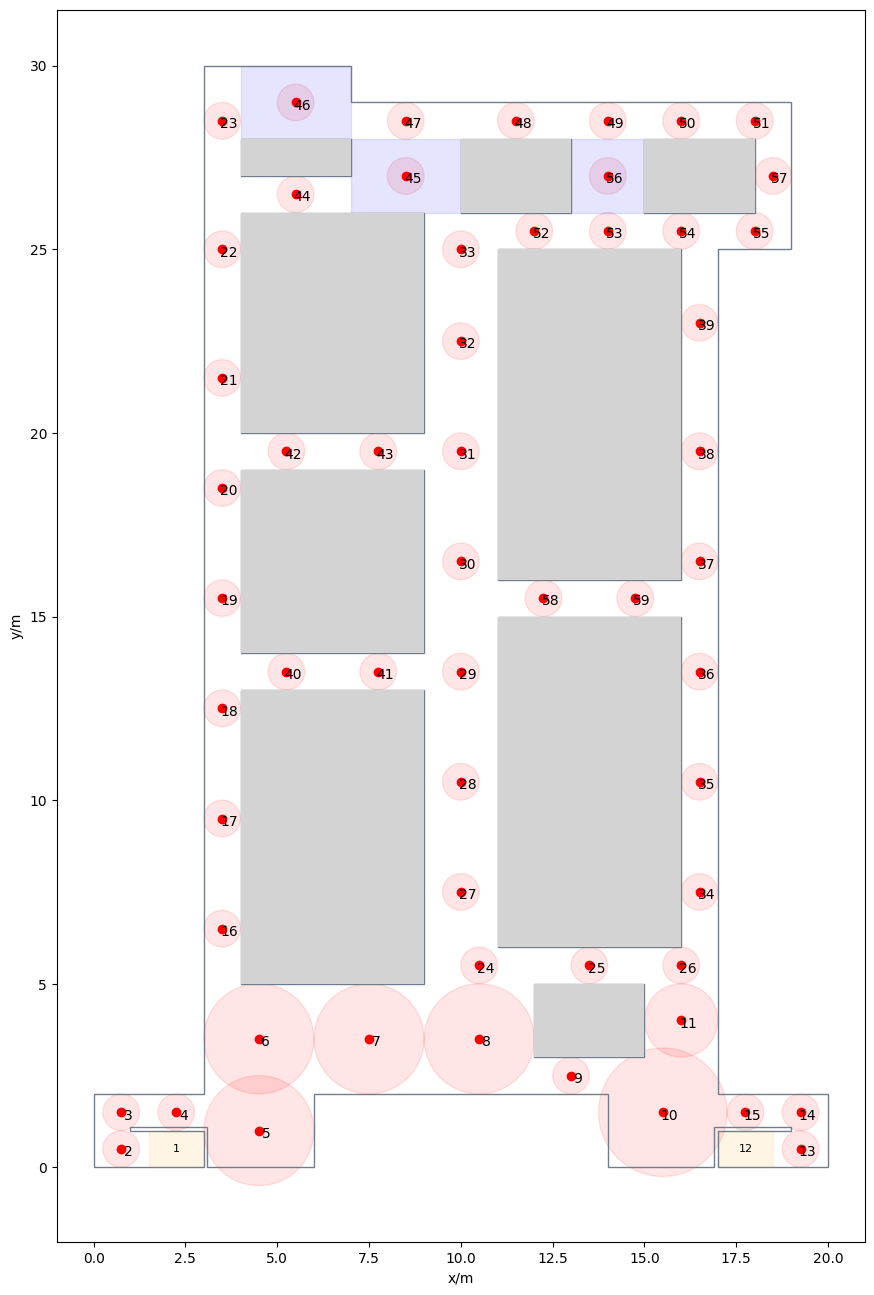

In [33]:
Environment_name = Environment.name
complete_area = Environment.complete_area
obstacles = Environment.obstacles
exit_polygons = Environment.exit_polygons
waypoints = Environment.waypoints
distribution_polygons = Environment.distribution_polygons
obstacle = Environment.obstacles
walkable_area = Environment.walkable_area
G = Environment.graph
sources = Environment.sources
targets = Environment.targets
specific_areas = Environment.specific_areas

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 16))
ax.set_aspect("equal")
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

for idx, (waypoint, distance) in waypoints.items():
    ax.plot(waypoint[0], waypoint[1], "ro")
    ax.annotate(
        f"{idx}",
        (waypoint[0], waypoint[1]),
        textcoords="offset points",
        xytext=(5, -5),
        ha="center",
    )
    circle = Circle(
        (waypoint[0], waypoint[1]), distance, fc="red", ec="red", alpha=0.1
    )
    ax.add_patch(circle)
for name, exit_polygon in exit_polygons.items():
    x, y = Polygon(exit_polygon).exterior.xy
    plt.fill(x, y, alpha=0.1, color="orange")
    centroid = Polygon(exit_polygon).centroid
    plt.text(centroid.x, centroid.y, f"{name}", ha="center", va="center", fontsize=8)

for name, pol in distribution_polygons.items():
    x, y = pol.exterior.xy
    plt.fill(x, y, alpha=0.1, color="blue")

## Configuration of Simulation Scenarios

In [34]:
# Dictionary to store simulations for different percentages of agents
simulations = {}

# List of modes of algorithms and awareness used for the simulation
modes = [0, 1, 2, 3]

# Total number of agents in the simulation (not currently used in this snippet)
total_agents = 5

# Loop over each percentage value to create a corresponding simulation
for mode in modes:
    # Define the output file path for storing the simulation trajectories
    trajectory_file = f"../../sqlite_data/{Environment_name}_modes_{mode}.sqlite"

    # Create a new simulation instance using JPS (JuPedSim)
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(  # Define the agent movement model
            strength_neighbor_repulsion=2.6,  # Strength of repulsion between neighboring agents
            range_neighbor_repulsion=0.1,  # Distance at which agents start repelling each other
            range_geometry_repulsion=0.05,  # Distance at which agents start avoiding obstacles
        ),
        geometry=walkable_area.polygon,  # Define the walkable area for the simulation
        trajectory_writer=jps.SqliteTrajectoryWriter(  # Specify where to store simulation results
            output_file=pathlib.Path(trajectory_file),  # Save output to the specified SQLite file
        ),
    )

    # Store the simulation object in the dictionary using the percentage as a key
    simulations[mode] = simulation

## Journey configuration

In [35]:
# In journey_configuration.py

## Allocate Agents

In [36]:
positions = dict()
for source in sources:
    positions[source] = jps.distribute_by_number(
        polygon=distribution_polygons[source],
        number_of_agents=total_agents,
        distance_to_agents=0.4,
        distance_to_polygon=0.5,
        seed=45131502,
    )

## Launching the Simulation

In [37]:
# False -> to use the default risk evolution, True -> random risk evolution
use_random_risk_layout = True

# Important parameters
risk_threshold = 0.5
gamma = 0.3
stairs_max_speed = 0.6
normal_max_speed = 1.2

# set agent groups
modes_names = ["Low_awareness_efficient_paths", "High_awareness_efficient_paths", "Low_awareness_centrality_path", "High_awareness_centrality_path"]
awareness_levels_per_group = [0, 1, 0, 1]
algorithm_per_group = [0, 0, 1, 1]

In [38]:
every_nth_frame_simulation = 4  # Interval of iterations for frames
                                # 4 is the simulation writers default

every_nth_frame_animation = 50  # Interval of frames for risk updates
                                # 50 is the animations default

# Simulation parameters
riskSimulationValues = RiskSimulationValues(3000, 0.05, risk_threshold)

# Establish a connection to the appropriate SQLite database
default_connection_file = f"../../sqlite_data/default_{Environment_name}_risks.db" # default risk evolution file
new_connection_file = f"../../sqlite_data/{Environment_name}_risks.db" # random risk evolution file
if use_random_risk_layout:
    connection_file = default_connection_file  # Use new database if random risk layout is enabled
else:
    connection_file = default_connection_file  # Use default database otherwise

connection = sqlite3.connect(connection_file)
try:
    if use_random_risk_layout:
        # Create or reset the risk table if random risk layout is enabled
        create_risk_table(connection)

        # Simulate risk propagation and store results in the database
        simulate_risk(riskSimulationValues, every_nth_frame_animation, G, exit_polygons.keys(), connection) # animation not every frame is shown in the animation
    # get first frame risk table
    risk_first_frame= get_risk_levels_by_frame(connection, 0)
finally:
    # Ensure the database connection is closed after operations
    connection.close()

In [39]:
trajectory_files = {}
agent_groups_per_mode = {}
agent_area_files = {}
for mode, simulation in simulations.items():

    agent_area_files[mode] = f"../../sqlite_data/agent_area_{Environment_name}_mode_{mode}.db"
    agent_area_connection = sqlite3.connect(agent_area_files[mode])

    create_agent_area_table(agent_area_connection)

    exit_ids = {}
    for node, exit_polygon in exit_polygons.items():
        exit_ids[node] = simulation.add_exit_stage(exit_polygon)

    # Initialize a dictionary to store waypoint IDs
    waypoints_ids = {}
    # Convert waypoints into simulation waypoints with associated distances
    for node, (waypoint, distance) in waypoints.items():
        waypoints_ids[node] = simulation.add_waypoint_stage(waypoint, distance)

    agent_groups = dict()
    for source in sources:

        agent_group_aux = AgentGroup(None, None, None, algorithm_per_group[mode], awareness_levels_per_group[mode])
        path = compute_alternative_path(exit_polygons.keys(), agent_group_aux, G, source, risk_per_node=risk_first_frame, gamma=gamma)

        # Set up a journey for the simulation
        journeys_ids = set_journeys(
            simulation, source, [path], waypoints_ids, exit_ids
        )

        # Retrieve the best path for the first source and its associated journey ID
        journey_id, best_path_source = journeys_ids[source][0]
        next_node = best_path_source[1]  # Get the next node on the best path
        first_waypoint_id = waypoints_ids[next_node]  # Determine the waypoint ID for the next node

        agents = set_agents_in_simulation(simulation, positions[source], journey_id, first_waypoint_id, normal_max_speed)

        agent_group_aux.path = path

        # currently unnecessary
        agents_initial_nodes = {}
        for agent in agents:
            agents_initial_nodes[agent] = path[0]
        agent_group_aux.current_nodes = agents_initial_nodes

        agent_group_aux.agents = agents

        agent_groups[source] = agent_group_aux

    simulation_config = SimulationConfig(simulation, every_nth_frame_simulation, every_nth_frame_animation, waypoints_ids, exit_ids, gamma, normal_max_speed, stairs_max_speed)

    connection = sqlite3.connect(connection_file)
    # Run the agent simulation, updating paths based on the risk levels
    run_agent_simulation(
        simulation_config,
        agent_groups,
        G,
        connection,
        agent_area_connection,
        risk_threshold=risk_threshold,  # Threshold for avoiding high-risk areas
    )

    connection.close()
    agent_area_connection.close()

    print(f"{mode} simulation finished")

    # Generate the trajectory file for the current percentage and store its path
    trajectory_file = f"../../sqlite_data/{Environment_name}_modes_{mode}.sqlite"
    trajectory_files[mode] = trajectory_file
    agent_groups_per_mode[mode] = agent_groups

0 simulation finished
1 simulation finished
2 simulation finished
3 simulation finished


In [40]:
# Open the database connection safely
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks = get_risks_grouped_by_frame(connection)

In [41]:
with sqlite3.connect(agent_area_files[2]) as connection:
    all_agent_areas = read_agent_area_data_by_frame(connection,500)

## Visualizing Agent Pathways

In [42]:
agent_trajectories = {}
for mode in modes:
    trajectory_file = trajectory_files[mode]
    agent_trajectories[mode], walkable_area = read_sqlite_file(
        trajectory_file
    )
    animate(
        agent_trajectories[mode],
        walkable_area,
        title_note=f"Mode: {modes_names[mode]}",
        risk_per_frame=all_risks,
        specific_areas=specific_areas
    ).show()

## Analysus if the results

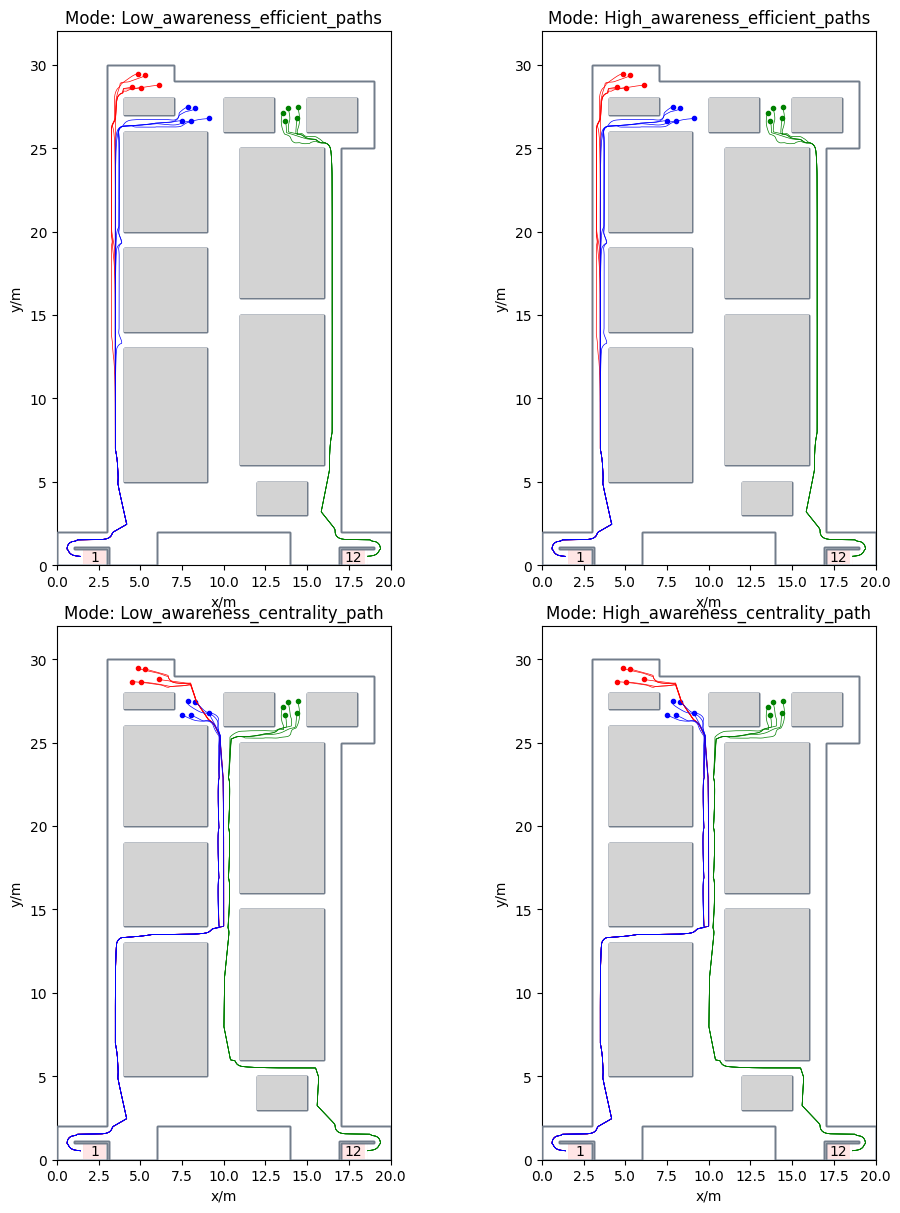

In [43]:
# show the hazzards of a specific frame
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks_frame_550 = get_risk_levels_by_frame(connection, 400)

risky_areas = []
for area, risk in all_risks_frame_550.items():
    if risk > 0.0:
        risky_areas.append((area, risk))

# Retrieve the boundary coordinates of the complete_area polygon
minx, miny, maxx, maxy = complete_area.bounds

# Create a figure with subplots arranged in two rows and two columns
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 16),
)

# Flatten the axes array to simplify iteration
axes = axes.flatten()

# Define a list of colors to differentiate agent groups in the plots
colors = ["red", "blue", "green"]

# Iterate over each subplot axis and its corresponding mode
for ax, mode in zip(axes, agent_groups_per_mode):
    # Extract trajectory data for the current mode
    trajectories = agent_trajectories[mode].data

    # Initialize a list to hold groups of agents for the current mode
    list_of_groups = []

    # Populate the list with agent groups from each source
    for source in sources:
        list_of_groups.append(agent_groups_per_mode[mode][source].agents)

    # Iterate over each group of agents
    for ig, group in enumerate(list_of_groups):
        # Create a TrajectoryData object for the current group
        traj = pedpy.TrajectoryData(
            trajectories[trajectories["id"].isin(group)],
            frame_rate=agent_trajectories[mode].frame_rate,
        )

        # Plot the trajectories of the current group on the current axis
        pedpy.plot_trajectories(
            traj=traj,
            walkable_area=walkable_area,
            axes=ax,
            traj_color=colors[ig],
            traj_width=0.5,
            traj_start_marker=".",
        )

    # Set the title of the subplot to indicate the current mode
    ax.set_title(f"Mode: {modes_names[mode]}")

    # Set the x and y axis limits based on the complete_area boundaries
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Ensure the aspect ratio is equal to maintain the scale of the plot
    ax.set_aspect('equal', adjustable='box')

    # Overlay exit polygons on the plot
    for name, exit_polygon in exit_polygons.items():
        # Extract the x and y coordinates of the polygon's exterior
        x, y = Polygon(exit_polygon).exterior.xy

        # Fill the polygon area with a semi-transparent red color
        ax.fill(x, y, alpha=0.1, color="red")

        # Outline the polygon with a white border
        ax.plot(x, y, color="white")

        # Calculate the centroid of the polygon
        centroid = Polygon(exit_polygon).centroid

        # Place the name of the exit at the centroid position
        ax.text(
            centroid.x, centroid.y, name, ha="center", va="center", fontsize=10
        )


    for area, risk_value in risky_areas:
        if risk_value > 0.0:
            x, y = specific_areas[area].exterior.xy
            if risk_value < risk_threshold:
                ax.fill(x, y, alpha=0.5, color="pink")
            else:
                ax.fill(x, y, alpha=0.5, color="purple")


# Adjust the layout to prevent overlapping elements
plt.tight_layout()

# Set the final size of the figure if needed
fig.set_size_inches((10, 12))

# Display the figure with all subplots
plt.show()


## Calculate profiles

### Step 1: Compute individual speeds and Voronoi cells for each mode

In [44]:
individual_speed_per_mode = dict()
individual_voronoi_cells_per_mode = dict()

# Loop over each mode in the list of modes
for mode in modes:
    # Compute individual speed for the current mode
    individual_speed = pedpy.compute_individual_speed(
        traj_data=agent_trajectories[mode],
        frame_step=5,
        speed_calculation=pedpy.SpeedCalculation.BORDER_SINGLE_SIDED,
    )

    # Compute individual Voronoi polygons for the current mode
    individual_voronoi_cells = pedpy.compute_individual_voronoi_polygons(
        traj_data=agent_trajectories[mode],
        walkable_area=walkable_area,
        cut_off=pedpy.Cutoff(radius=0.8, quad_segments=3),
    )

    # Save the computed data into dictionaries keyed by mode
    individual_speed_per_mode[mode] = individual_speed
    individual_voronoi_cells_per_mode[mode] = individual_voronoi_cells

### Step 2: Compute density and speed profiles for each mode

In [ ]:
# Define the frame range for profile computation
min_frame_profiles = 600
max_frame_profiles = 700

# Initialize dictionaries to store density and speed profiles per mode
density_profiles_per_mode = dict()
speed_profiles_per_mode = dict()

# Loop over each mode to calculate the profiles
for mode in modes:
    # Filter the Voronoi data for frames within the desired range
    voronoi_filtered = individual_voronoi_cells_per_mode[mode][
        individual_voronoi_cells_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Filter the speed data for frames within the desired range
    speed_filtered = individual_speed_per_mode[mode][
        individual_speed_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Merge the filtered Voronoi and speed data on 'id' and 'frame'
    merged_data = pd.merge(
        voronoi_filtered,
        speed_filtered,
        on=["id", "frame"],
    )

    # Compute density and speed profiles using the merged data
    density_profiles, speed_profiles = pedpy.compute_profiles(
        individual_voronoi_speed_data=merged_data,
        walkable_area=walkable_area.polygon,
        grid_size=0.25,
        speed_method=pedpy.SpeedMethod.ARITHMETIC,
    )

    # Save the computed profiles in the corresponding dictionaries
    density_profiles_per_mode[mode] = density_profiles
    speed_profiles_per_mode[mode] = speed_profiles

### Step 3: Plot profiles with one row per mode and two columns per row
<div style="margin-left: 60px;"><h4>(first column: density, second column: speed)</h4></div>


In [ ]:
num_modes = len(modes)
fig, axes = plt.subplots(nrows=num_modes, ncols=2, figsize=(12, 4 * num_modes))

for idx, mode in enumerate(modes):
    # Seleccionamos el eje para densidad (columna 0) y para velocidad (columna 1)
    ax_density = axes[idx, 0]
    ax_speed = axes[idx, 1]

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=density_profiles_per_mode[mode],
        axes=ax_density,
        label="$\\rho$ / 1/$m^2$",
        vmin=0,
        vmax=10,
        title=f"Density - {modes_names[mode]}",
    )

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=speed_profiles_per_mode[mode],
        axes=ax_speed,
        label="v / m/s",
        vmin=0,
        vmax=2,
        title=f"Speed - {modes_names[mode]}",
    )

fig.tight_layout(pad=2)
plt.show()

## Evacuation Times vs Mode

In [ ]:
evac_times = []
for mode, traj in agent_trajectories.items():
    t_evac = traj.data["frame"].max() / traj.frame_rate # time equals frame / frame rate
    evac_times.append(t_evac)

for mode in modes:
    print(f"Mode: {modes_names[mode]}, time: {evac_times[mode]:2f}")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(modes_names),
        y=evac_times,
        marker=dict(size=10),
        mode="lines+markers",
        name="Evacuation Times",
    )
)

fig.update_layout(
    title="Evacuation Times vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Evacuation Time (s)",
)

fig.show()

## Risk vs Mode

In [ ]:
avg_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            avg_risk[mode] = get_average_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, average risk: {avg_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(avg_risk.values()),
        name="Average Risks"
    )
)

fig.update_layout(
    title="Average Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

In [ ]:
risk_sum = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            risk_sum[mode] = calculate_average_agent_combined_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, total risk: {risk_sum[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(risk_sum.values()),
        name="Total Risks"
    )
)

fig.update_layout(
    title="Total Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

In [ ]:
highest_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            highest_risk[mode] = get_max_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, highest risk: {highest_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(highest_risk.values()),
        name="Highest Risks"
    )
)

fig.update_layout(
    title="Highest Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()